In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import requests
from io import BytesIO
from bs4 import BeautifulSoup as bs
from IPython.display import HTML
from datetime import datetime
import json

In [2]:
def get_df(id, year):
    response = requests.get("https://www.nwac.us/data-portal/csv/q", {"datalogger_id": id, "year": year})
    return pd.read_csv(BytesIO(response.content))

def get_soup(url):
    page = requests.get(url)
    return bs(page.text, 'lxml')

def get_portal_urls():
    soup = get_soup("https://www.nwac.us/data-portal/")
    elms = soup.find("div", {"class": "entry-content"}).findAll("li")
    return [elm.find("a")["href"] for elm in elms]

def get_options(url):
    soup = get_soup("https://www.nwac.us" + url)
    optionElements = soup.findAll("select", {"name": "datalogger_id"})[0].findAll("option")
    return ([option.text for option in optionElements], [option["value"] for option in optionElements])

def get_fetch_portals(values):
    return [f"/data-portal/location/{v}/" for v in values]

In [38]:
def interpolate(values, lower, upper):
    new_list = []
    for idx in range(len(values)):
        value = values[idx]
        if value > upper or value < lower:
            new_list.append(new_list[idx-1])
        else:
            new_list.append(value)
    return new_list
    
def get_r_theta(theta_col, r_col, days, offset):
    start = (-days * 24) - (offset * 24)
    end = -offset * 24
    theta = (theta_col.astype('float')[start:end-1]/180.0) * np.pi
    r = r_col.astype('float')[start:end-1]
    return [[x,y] for x,y in zip(list(theta), list(r))]

def get_radial_animation(theta_col, r_col, days, offset):
    data = np.array([get_r_theta(theta_col, r_col, days, offset+1-x) for x in range(offset+1)])
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.set_theta_zero_location("N")
    ax.set_ylim(0,max(r_col))
    scat = ax.scatter([0]*len(data), [0]*len(data))
    return animation.FuncAnimation(fig, update_plot, frames=range(len(data)),
                                  fargs=(data, scat)) 

def update_plot(i, data, scat):
    scat.set_offsets(data[i])
    return scat

In [4]:
portals = get_portal_urls()

In [5]:
portals

['/data-portal/location/hurricane-ridge/',
 '/data-portal/location/mt-baker-ski-area/',
 '/data-portal/location/washington-pass/',
 '/data-portal/location/lake-wenatchee/',
 '/data-portal/location/stevens-pass/',
 '/data-portal/location/snoqualmie-pass/',
 '/data-portal/location/mt-rainier/',
 '/data-portal/location/white-pass-ski-area/',
 '/data-portal/location/mt-st-helens/',
 '/data-portal/location/mt-hood/',
 '/data-portal/location/crystal/',
 '/data-portal/location/chinook-pass/']

In [6]:
fetch_portals = get_fetch_portals(['snoqualmie-pass'])
df_list = {}
year = 2021
cumulatives = ['Precipitation  (") ']
for portal in fetch_portals:
    names, ids = get_options(portal)
    for name, id in zip(names, ids):
        df_list[name] = get_df(id, year)
        df_list[name]['Date/Time (PST)'] = pd.to_datetime(df_list[name]['Date/Time (PST)'])
        df_list[name] = df_list[name].sort_values('Date/Time (PST)', ascending=True)
        for c in cumulatives:
            if c in df_list[name].columns:
                key = f'CUM {c}'
                df_list[name][key] = df_list[name][c].cumsum() 

In [8]:
stations = list(df_list.keys())
stations

["Alpental Base, 3100'",
 "Alpental Mid-Mountain, 4350'",
 "Alpental Summit, 5470'",
 "Mt. Washington, 4340'",
 "Snoqualmie Pass, 3010'",
 "Snoqualmie Pass - Dodge Ridge, 3760'",
 "Snoqualmie Pass - East Shed, 3770'"]

In [42]:
station = "Snoqualmie Pass - Dodge Ridge, 3760'"
df = df_list[station]
df['Date/Time (PST)'] = pd.to_datetime(df['Date/Time (PST)'])
df = df.sort_values('Date/Time (PST)', ascending=True).reset_index()
df.head()

index     Date/Time (PST)  Battery Voltage  (v)   Temperature  (deg F)   \
0   8759 2021-01-01 00:00:00                  13.03                  33.29   
1   8758 2021-01-01 00:01:00                    NaN                    NaN   
2   8757 2021-01-01 01:00:00                  13.03                  32.75   
3   8756 2021-01-01 02:00:00                  13.03                  31.38   
4   8755 2021-01-01 03:00:00                  13.03                  30.97   

   Relative Humidity  (%)   Precipitation  (")   Total Snow Depth  (")   \
0                      NaN                  NaN                     NaN   
1                      NaN                  NaN                     NaN   
2                      NaN                  NaN                     NaN   
3                      NaN                  NaN                     NaN   
4                      NaN                  NaN                     NaN   

   Wind Direction  (deg.)   Wind Speed Average  (mph)   \
0                    55.69                       7.418   
1                      NaN                         NaN   
2                   104.20                      12.600   
3                   104.00                      13.310   
4                   111.60                      15.480   

   Wind Speed Minimum  (mph)   ...  24 Hour Snow  (")   \
0                       1.412  ...                 NaN   
1                         NaN  ...                 NaN   
2                       5.294  ...                 NaN   
3                       9.880  ...                 NaN   
4                      11.650  ...                 NaN   

   Intermittent/Shot Snow  (")   Net Solar  (mJ/m2)   Soil Moisture A  (VWC)   \
0                           NaN                  NaN                      NaN   
1                           NaN                  NaN                      NaN   
2                           NaN                  NaN                      NaN   
3                           NaN                  NaN                      NaN   
4                           NaN                  NaN                      NaN   

   Soil Moisture B  (VWC)   Soil Moisture C  (VWC)   \
0                      NaN                      NaN   
1                      NaN                      NaN   
2                      NaN                      NaN   
3                      NaN                      NaN   
4                      NaN                      NaN   

   Soil Temperature A  (deg F)   Soil Temperature B  (deg F)   \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   Soil Temperature C  (deg F)   CUM Precipitation  (")   
0                           NaN                      NaN  
1                           NaN                      NaN  
2                           NaN                      NaN  
3                           NaN                      NaN  
4                           NaN                      NaN  

[5 rows x 24 columns]

In [34]:
[1, 2, 3, 4, 5, 6, 7][-1:]

[7]

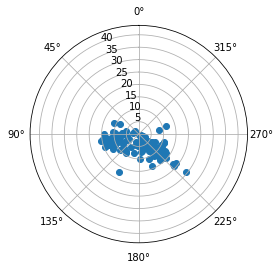

In [52]:
window = 5
offset = 100
last_n_days = -200 * 24

if last_n_days > 0:
    filtered = df.iloc[-1*last_n_days:]
else:
    filtered = df
    
X = filtered['Wind Direction  (deg.) ']
Y = filtered['Wind Speed Average  (mph) ']
ani = get_radial_animation(X, Y, window, offset)
HTML(ani.to_jshtml())

Temperature  (deg F) 


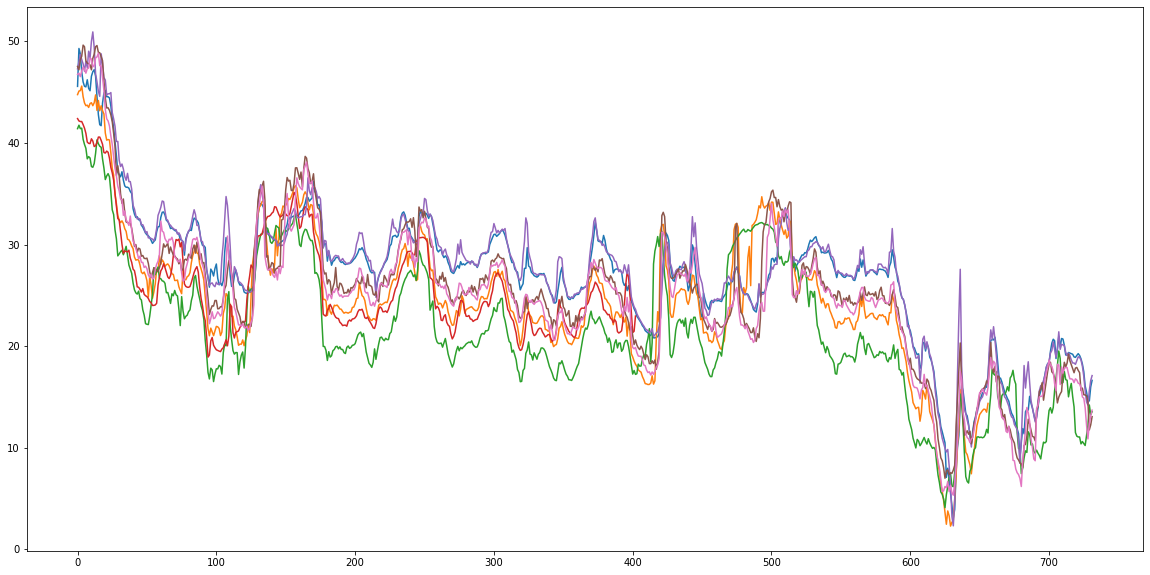

CUM Precipitation  (") 


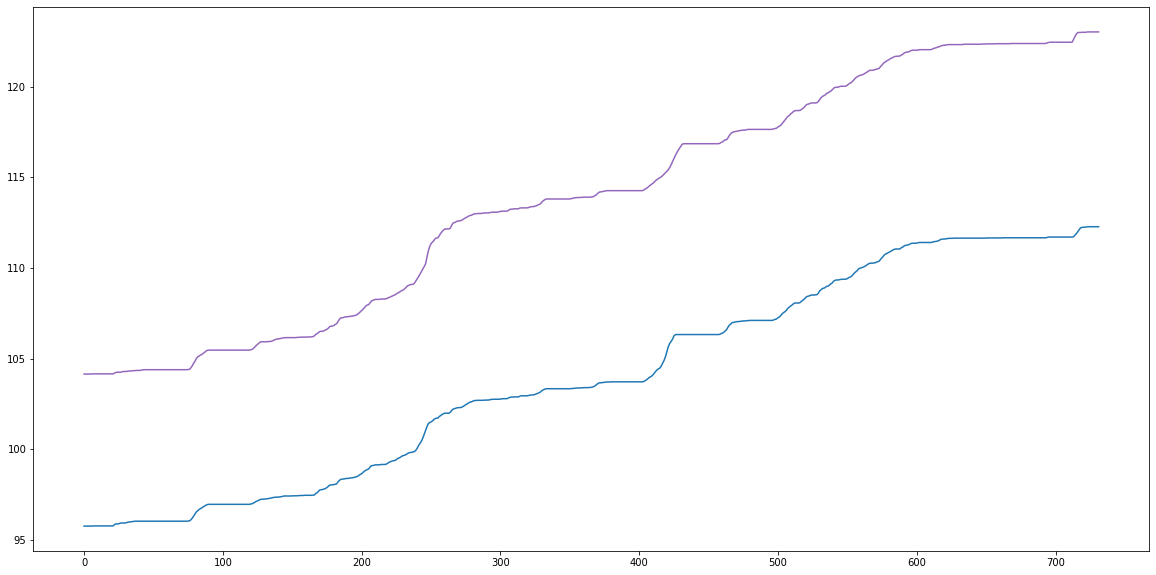

Total Snow Depth  (") 


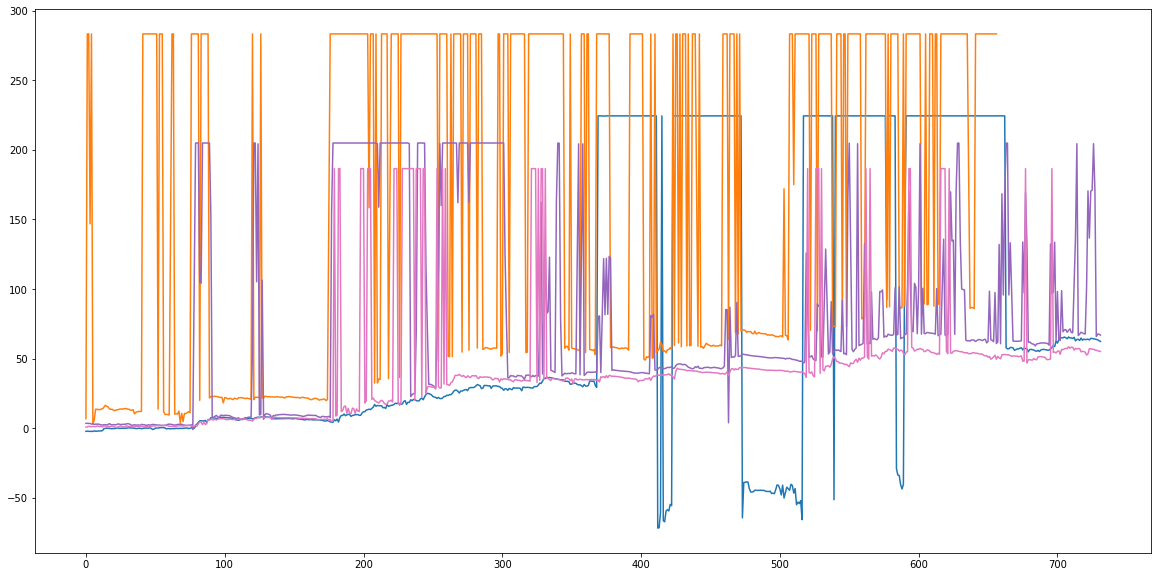

In [206]:
attributes = ['Temperature  (deg F) ', 'CUM Precipitation  (") ', 'Total Snow Depth  (") ']
date_limit = datetime(2021, 12, 1, 0)
for attribute in attributes:
    plt.figure(figsize=(20,10))
    for station in stations:
        df = df_list[station]
        filtered = df[df['Date/Time (PST)'] > date_limit].set_index('Date/Time (PST)')
        
        if attribute in df.columns:
            values = list(filtered[attribute])
            mean = np.mean(values)
            std = np.std(values)
            limit = mean + (std * 3)

            X = range(0, len(filtered))
            Y = values #interpolate(values, 0, limit)
            
            
            plt.plot(X, Y)

    print(attribute)    
    plt.show()